### Exercise 63

#### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma
from scipy.stats import gaussian_kde as kde

#### Data

In [2]:
df = pd.read_csv('mining.csv')
xy = df.to_numpy()
x, y = xy[:, 0], xy[:, 1]
n = len(y)

#### Plot

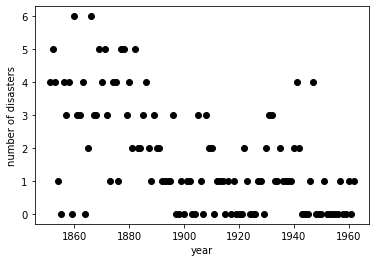

In [3]:
plt.scatter(x, y, color='black')
plt.xlabel('year')
plt.ylabel('number of disasters')
plt.show()

#### (a)

#### Parameters

In [4]:
alpha, beta = 1, 1
sim = 1_000
mplot = 200

#### Functions

In [5]:
def logsumexp(x):
    xstar = np.max(x)
    return xstar + np.log(np.sum(np.exp(x - xstar)))


def update_tau(lambda1, lambda2, y, n):
    logprobs = np.zeros(n)
    for i in range(n):
        y1 = y[:i]
        y2 = y[i:]
        
        logprob1 = np.sum(poisson(lambda1).logpmf(y1))
        logprob2 = np.sum(poisson(lambda2).logpmf(y2))
        logprob = logprob1 + logprob2
        logprobs[i] = logprob
    logprobs -= logsumexp(logprobs)
    probs = np.exp(logprobs)
    
    return np.random.choice(np.arange(n), p=probs)


def update_lambda1(tau, lambda2, y, n, alpha, beta):
    y1 = y[:tau]
    return gamma(a=alpha + np.sum(y1), scale=1 / (beta + len(y1))).rvs()


def update_lambda2(tau, lambda1, y, n, alpha, beta):
    y2 = y[tau:]
    return gamma(a=alpha + np.sum(y2), scale = 1 / (beta + len(y2))).rvs()

#### Gibbs sampling

In [6]:
sample = np.zeros((sim, 3))
sample[0] = np.array([n // 2, np.mean(y), np.mean(y)])

In [7]:
for s in range(sim - 1):
    if s % 100 == 0:
        print(s)
    tau, lambda1, lambda2 = sample[s]
    new_tau = update_tau(lambda1, lambda2, y, n)
    new_lambda1 = update_lambda1(new_tau, lambda2, y, n, alpha, beta)
    new_lambda2 = update_lambda2(new_tau, new_lambda1, y, n, alpha, beta)
    sample[s + 1] = np.array([new_tau, new_lambda1, new_lambda2])

0
100
200
300
400
500
600
700
800
900


#### Posterior

##### Tau

In [8]:
tau_posterior = np.zeros(n)
for i in range(n):
    tau_posterior[i] = np.sum(sample[:, 0] == i) / sim

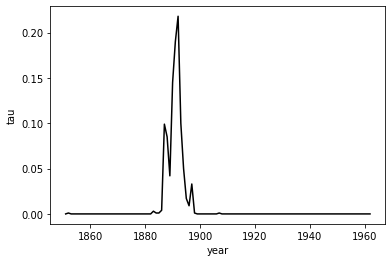

In [9]:
plt.plot(x[0] + np.arange(n), tau_posterior, color='black')
plt.xlabel('year')
plt.ylabel('tau')
plt.show()

In [10]:
tauMAP = x[0] + np.argmax(tau_posterior)
print(f'Posterior mode: {tauMAP}')

Posterior mode: 1892


##### Lambdas

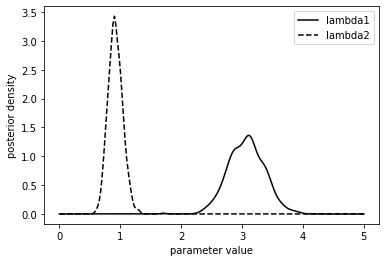

In [13]:
space = np.linspace(0, 5, mplot)
plt.plot(space, kde(sample[:, 1])(space), color='black', label='lambda1')
plt.plot(space, kde(sample[:, 2])(space), color='black', linestyle='dashed', label='lambda2')
plt.xlabel('parameter value')
plt.ylabel('posterior density')
plt.legend()
plt.show()

#### (b)

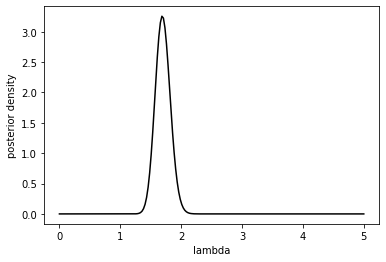

In [15]:
space = np.linspace(0, 5, mplot)
plt.plot(space, gamma(a=(alpha + np.sum(y)), scale=1/(beta + n)).pdf(space), color='black')
plt.xlabel('lambda')
plt.ylabel('posterior density')
plt.show()